# ProRes Frames to Zarr Example
Here we write original ProRes compressed frames into a zarr array and show how to work with this database using lazy operations.

#### Imports

In [1]:
%matplotlib inline
import pycamhd.pycamhd as camhd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

#### Create a list of frames to analyze using the dbcamhd.json database

In [2]:
dbcamhd = pd.read_json('dbcamhd.json', orient="records", lines=True)
dbcamhd.tail()

,deployment,filename,filesize,frame_count,moov,timestamp
8423,4,https://rawdata.oceanobservatories.org/files/R...,596503857,26981,True,1522627201
8424,4,https://rawdata.oceanobservatories.org/files/R...,595973297,26957,True,1522638002
8425,4,https://rawdata.oceanobservatories.org/files/R...,596481805,26980,True,1522648801
8426,4,https://rawdata.oceanobservatories.org/files/R...,596459753,26979,True,1522659601
8427,4,https://rawdata.oceanobservatories.org/files/R...,595840657,26951,True,1522670402


In [3]:
fileindex = 2064
filename = dbcamhd.filename[fileindex]
frame_count = dbcamhd.frame_count[fileindex]
n_images = 10
frame_numbers = np.linspace(750,frame_count-6000, n_images, dtype=np.int64())
filename

'https://rawdata.oceanobservatories.org/files/RS03ASHS/PN03B/06-CAMHDA301/2016/07/29/CAMHDA301-20160729T000000Z.mov'

In [4]:
frame_numbers[0:10]

array([  750,  2797,  4844,  6891,  8938, 10985, 13032, 15079, 17126,
       19173])

#### Create timestamps for frames

In [5]:
from datetime import datetime

In [6]:
timestamps = []
for i in range(len(frame_numbers)):
    timestamps.append(datetime.fromtimestamp(dbcamhd.timestamp[fileindex] + frame_numbers[i]/29.95))

In [7]:
timestamps[0:5]

[datetime.datetime(2016, 7, 29, 0, 0, 26, 41736),
 datetime.datetime(2016, 7, 29, 0, 1, 34, 388982),
 datetime.datetime(2016, 7, 29, 0, 2, 42, 736227),
 datetime.datetime(2016, 7, 29, 0, 3, 51, 83472),
 datetime.datetime(2016, 7, 29, 0, 4, 59, 430718)]

#### Create Xarray Dataset from Dask delayed functions
Here instead of calling get_frame, we call get_frame_data which returns the raw ProRes encoded frame. The encoded data has a compression ratio of about 10:1, so storage costs will be lower and transfer rates (in terms of frames/s) should be higher.

In [8]:
from dask import delayed
import dask.array as da

In [9]:
def get_frame_data_array(filename, frame_number, moov_atom=False):
    return np.array(camhd.get_frame_data(filename, frame_number, moov_atom), dtype='bytes')[None,]

In [10]:
test_data = get_frame_data_array(filename, frame_numbers[4])

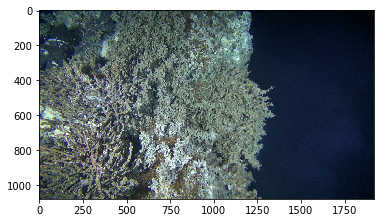

In [11]:
plt.imshow(camhd.decode_frame_data(test_data, 'rgb24'));

In [12]:
moov_atom = camhd.get_moov_atom(filename)
delayed_frame_data = []
for frame_number in frame_numbers:
    delayed_frame_data.append(da.from_delayed(
                              delayed(get_frame_data_array)(filename, frame_number, moov_atom),
                              shape=(1,), dtype='bytes'))

In [13]:
delayed_frame_data[0]

dask.array<from-value, shape=(1,), dtype=|S0, chunksize=(1,)>

In [14]:
ds = xr.DataArray(da.concatenate(delayed_frame_data, axis=0),dims=['time'], coords={'time': timestamps}).to_dataset(name='video')
ds

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-29T00:00:26.041736 ...
Data variables:
    video    (time) |S0 dask.array<shape=(10,), chunksize=(1,)>

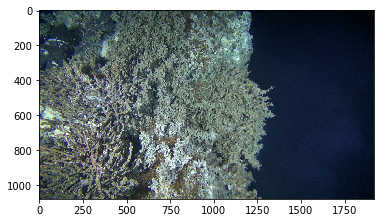

In [15]:
plt.imshow(camhd.decode_frame_data(ds.video[4].values, 'rgb24'));

#### Save to local zarr group

In [16]:
ds.to_zarr('test.zarr', mode='w')

#### Open zarr group and plot image

In [17]:
del ds
ds = xr.open_zarr('test.zarr')

In [18]:
plt.imshow(camhd.decode_frame_data(ds.video[4].values, 'rgb24'));

ValueError: itemsize cannot be zero in type